# Sentiment Analysis using Logistic Regression

This notebook performs sentiment analysis using logistic regression to classify text as positive or negative. It’s worth noting that no advanced machine learning libraries are used for the logistic regression implementation. I have built the model from scratch. After that, I will use scikit-learn to make a comparative analysis.

The dataset used in this project is from [Kaggle](https://www.kaggle.com/datasets/mdismielhossenabir/sentiment-analysis).  


## Table of Contents
1. [Import Libraries](#import)
2. [Dataset Information](#load)
3. [Feature Selection / EDA](#fs)
4. [Data Preprocessing](#preprocess)
5. [Model Training](#train)
6. [Main Execution](#ME)
7. [Scikit-Learn Implementation](#scikit)


## 1. Import Libraries <a id="import"></a>

In [92]:
import pandas as pd
import numpy as np
import random
import string
import re
import emoji
from scipy.sparse import hstack, csr_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer 


## 2. Dataset Information <a id="load"></a>

In [93]:
data = pd.read_csv("C:/Users/USER/Desktop/Sentiment Analysis/sentiment_analysis.csv")
data = data[data['sentiment'] != 'neutral'] 
data.head(5)

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram


In [94]:
data.describe()
# For now we only have3 numeric valued columns, we will do some preprocessing on this to convert
# our some data type of columns to integer data type, as LR works with numeric values. 


,Year,Month,Day
count,300.000000,300.000000,300.000000
mean,2020.353333,5.790000,15.586667
std,2.905736,3.678451,8.542780
min,2011.000000,1.000000,1.000000
25%,2018.000000,2.000000,8.000000
50%,2021.000000,6.000000,15.000000
75%,2023.000000,9.000000,22.000000
max,2023.000000,12.000000,30.000000


In [95]:
data.isnull().sum()
# As you can see below we have no NULL value for any column in our dataset

Year             0
Month            0
Day              0
Time of Tweet    0
text             0
sentiment        0
Platform         0
dtype: int64

In [96]:
data['sentiment'].value_counts(normalize=True)

# The dataset is not perfectly balanced yet it will not hurt our process as we are planning to use StratifiedKFold library. 

sentiment
positive    0.553333
negative    0.446667
Name: proportion, dtype: float64

## 3. Feature Selection / EDA <a id="fs"></a>
In this part of the project I will explore some relations between features and target to choose the best features to train our model on. 

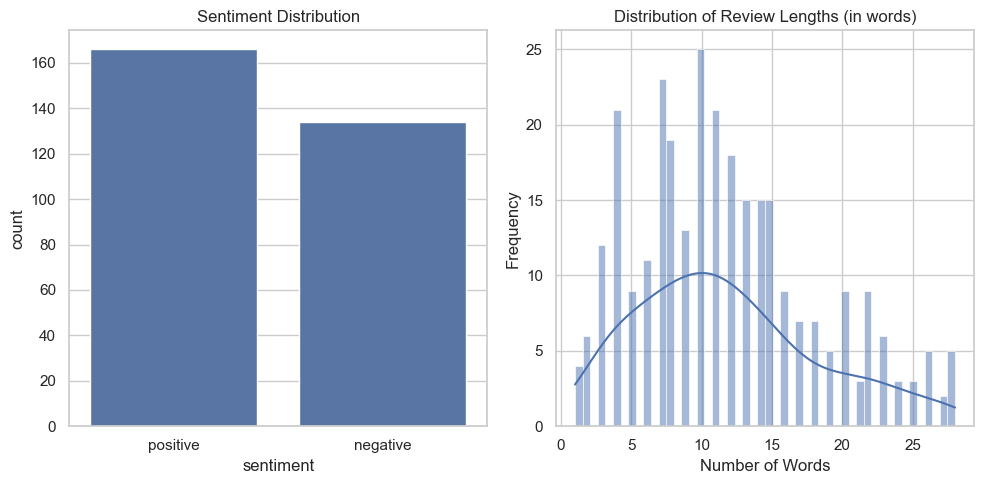

In [97]:
# Compute review lengths
data['text_length'] = data['text'].apply(lambda x: len(str(x).split()))

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot 1: Sentiment Distribution
sns.countplot(x=data['sentiment'], ax=axes[0])
axes[0].set_title("Sentiment Distribution")

# Plot 2: Review Length Distribution
sns.histplot(data['text_length'], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Review Lengths (in words)")
axes[1].set_xlabel("Number of Words")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

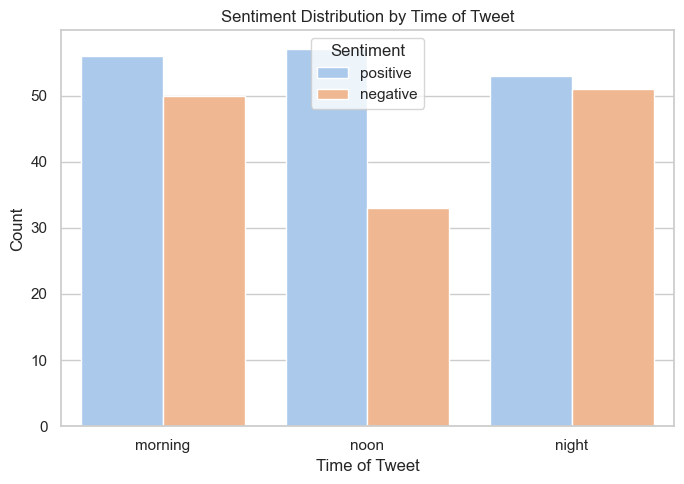

In [98]:
# Set plot style
sns.set(style="whitegrid")
# Countplot: Sentiment distribution for each Time of Tweet
plt.figure(figsize=(7, 5))
sns.countplot(data=data, x="Time of Tweet", hue="sentiment", palette="pastel")

plt.title("Sentiment Distribution by Time of Tweet")
plt.xlabel("Time of Tweet")
plt.ylabel("Count")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

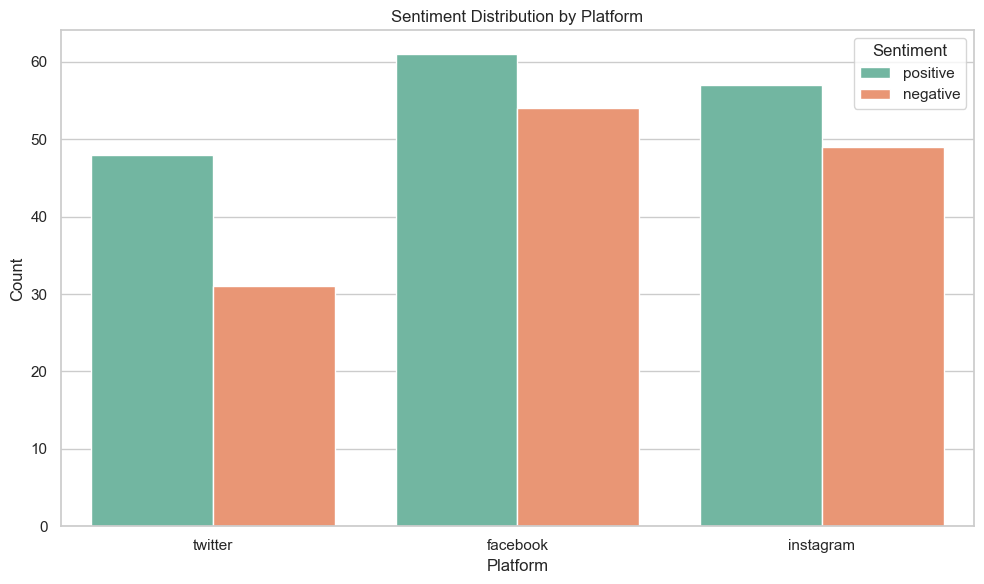

In [99]:
# I have observed that there is some inconsistency among the names of platforms Facebook and facebook are treated as different platforms so we do the following: 
data['Platform'] = data['Platform'].str.lower().str.strip() 

plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Platform', hue='sentiment', palette='Set2')

plt.title("Sentiment Distribution by Platform")
plt.xlabel("Platform")
plt.ylabel("Count")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


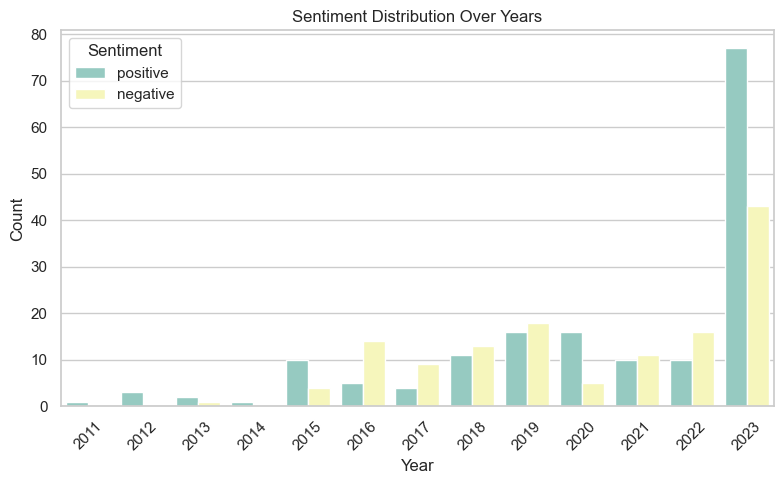

In [100]:
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='Year', hue='sentiment', palette='Set3')

plt.title("Sentiment Distribution Over Years")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Summary of Observations:
- The dataset is slightly imbalanced, with a bit more positive reviews than negative ones. However, the difference isn't too large, so we’ll go ahead and use it as-is for learning purposes :)

- The reviews are generally short, mostly around 5–10 words, with fewer longer texts.

- When looking at the time of tweet, people tend to express more positive sentiment around noon, and less negative sentiment in the morning and midday. At night, the sentiment distribution becomes a bit more balanced. So, the "Time of Tweet" feature might be helpful for our model.

- Regarding the platform used, positive comments are more common across all platforms. However, Twitter shows a stronger imbalance, with significantly more positive than negative comments. Facebook and Instagram are more balanced in comparison. So, we’ll keep "Platform" as a feature as well.

- Over the years, sentiment trends (both positive and negative) have changed quite a bit. This suggests that the "Year" column could also carry meaningful information, so we’ll include it as a feature too.

## 4. Data Preprocessing <a id="preprocess"></a>

In [101]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = emoji.demojize(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'[\"$%&()*+,-./:;<=>[\]^_{|}~]', ' ', text)
    words = text.split()
    clean_words = []
    for word in words:
        if word not in stop_words and len(word) >= 3:
            word = lemmatizer.lemmatize(word)
            clean_words.append(word)
    return ' '.join(clean_words)

def prepare_features(X_df, vectorizer=None, scaler=None, fit=True):
    X_df = X_df.copy()
    X_df = pd.get_dummies(X_df, columns=['Time of Tweet', 'Platform'], drop_first=False)

    # Text preprocessing
    X_df['text'] = X_df['text'].apply(preprocess_text)

    # TF-IDF
    if fit:
        vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
        X_text_tfidf = vectorizer.fit_transform(X_df['text'])
    else:
        X_text_tfidf = vectorizer.transform(X_df['text'])

    # Year scaling
    if fit:
        scaler = StandardScaler()
        year_scaled = scaler.fit_transform(X_df[['Year']].astype(float))
    else:
        year_scaled = scaler.transform(X_df[['Year']].astype(float))

    # Other features
    X_ohe = X_df.drop(columns=['Year', 'text']).values
    X_nontxt = np.hstack([year_scaled, X_ohe])

    # Final feature matrix
    X_final = hstack([csr_matrix(X_nontxt), X_text_tfidf])

    return X_final, vectorizer, scaler

### 📌 Feature Preprocessing Summary

This section defines the **text preprocessing** and **feature preparation pipeline** used for training the sentiment analysis model.

#### 1. `preprocess_text(text)`
Cleans and processes raw text:
- Converts emojis to text (e.g., 😀 → `:grinning_face:`)
- Converts all characters to lowercase
- Removes:
  - URLs (http, www, etc.)
  - Mentions (e.g., `@user`)
  - Hashtags (e.g., `#happy` → `happy`)
  - Punctuation and special characters
- Splits the text into words
- Removes common English stopwords (like “the”, “is”, etc.)
- Lemmatizes each word to its base form (e.g., “running” → “run”)
- Returns a clean, space-separated string of important words.

#### 2. `prepare_features(X_df, vectorizer=None, scaler=None, fit=True)`
Transforms the dataset into model-ready numerical features:
- One-hot encodes the categorical columns: `Time of Tweet` and `Platform`
- Applies `preprocess_text()` to clean the text data
- Converts the cleaned text into **TF-IDF vectors** (bigrams, max 5000 features)
- Scales the `Year` column using **standardization** (zero mean, unit variance)
- Concatenates:
  - Scaled year
  - One-hot encoded categorical features
  - TF-IDF text features
- Returns a **sparse matrix of final features**, along with:
  - `vectorizer` — the TF-IDF vectorizer (used for test data later)
  - `scaler` — the year scaler (used for test data later)

This function works for both training and testing phases:
- `fit=True`: fits vectorizer and scaler on training data
- `fit=False`: uses provided vectorizer and scaler to transform test data


## 5. Model Training - Logistic Regression from Scratch <a id="train"></a>

In [102]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def hypothesis(X, Theta):
    return 1 / (1 + np.exp(-np.dot(X, Theta)))

def gradient_descent(X, Y, Theta, alpha=0.01, iters=200000, lambda_=0.0001):
    m = len(Y)
    for i in range(iters):
        pred = hypothesis(X, Theta)
        error = pred - Y
        grad = (1/m) * np.dot(X.T, error)
        grad[1:] += (lambda_ / m) * Theta[1:]
        Theta -= alpha * grad
    return Theta

def train_with_cross_validation(X_full, y_full):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
    best_thresholds = []
    
    fold = 1
    for train_index, test_index in skf.split(X_full, y_full):
        print(f"\n--- Fold {fold} ---")
        X_train_df, X_test_df = X_full.iloc[train_index], X_full.iloc[test_index]
        y_train, y_test = y_full[train_index], y_full[test_index]

        # Align test columns with train
        X_train_final, vectorizer, scaler = prepare_features(X_train_df, fit=True)
        X_test_final, _, _ = prepare_features(X_test_df, vectorizer=vectorizer, scaler=scaler, fit=False)

        # Train model
        X_train_dense = X_train_final.toarray()
        X = np.hstack((np.ones((X_train_dense.shape[0], 1)), X_train_dense))
        Y = y_train.astype(float)
        Theta = np.zeros(X.shape[1])
        Theta = gradient_descent(X, Y, Theta)

        # Predict
        X_test_dense = X_test_final.toarray()
        X_eval = np.hstack((np.ones((X_test_dense.shape[0], 1)), X_test_dense))
        y_probs = hypothesis(X_eval, Theta)
        y_true = y_test

        # Tune threshold
        thresholds = np.arange(0.1, 0.9, 0.05)
        best_f1, best_threshold = 0, 0.5
        for t in thresholds:
            y_pred = (y_probs >= t).astype(int)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = t

        y_pred = (y_probs >= best_threshold).astype(int)

        # Evaluate
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        accuracy_list.append(acc)
        precision_list.append(prec)
        recall_list.append(rec)
        f1_list.append(f1)
        best_thresholds.append(best_threshold)

        print(f"Best Threshold: {best_threshold:.2f}")
        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
        fold += 1

    print("\n--- Average Results Across Folds ---")
    print(f"Accuracy: {np.mean(accuracy_list)*100:.2f}%")
    print(f"Precision: {np.mean(precision_list)*100:.2f}%")
    print(f"Recall: {np.mean(recall_list)*100:.2f}%")
    print(f"F1 Score: {np.mean(f1_list)*100:.2f}%")

### 📌 Training and Evaluation Summary

This section defines the **logistic regression training pipeline** using **manual gradient descent** and **5-fold Stratified Cross-Validation** for evaluation.

#### 1. `hypothesis(X, Theta)`
- Computes the **sigmoid function**:  

- Returns predicted probabilities for each instance.

#### 2. `gradient_descent(X, Y, Theta, alpha=0.01, iters=200000, lambda_=0.0001)`
- Performs **batch gradient descent** to minimize logistic loss with **L2 regularization**.
- Inputs:
  - `X`: Feature matrix (with bias term added manually)
  - `Y`: Binary labels
  - `Theta`: Weight vector (initialized to zeros)
  - `alpha`: Learning rate
  - `iters`: Number of iterations (200,000)
  - `lambda_`: Regularization strength
- Returns the optimized weights `Theta`.

#### 3. `train_with_cross_validation(X_full, y_full)`
Performs training and evaluation using **Stratified 5-Fold Cross-Validation**:

For each fold:
- Splits the data into train and test sets using `StratifiedKFold` to preserve class distribution.
- Applies `prepare_features()` to process both train and test data (ensuring consistent encoding and scaling).
- Trains logistic regression using `gradient_descent()`.
- Predicts class probabilities using the `hypothesis()` function.
- Searches over thresholds from `0.1` to `0.85` to find the **best F1 score**.
- Evaluates predictions using:
  - **Accuracy**
  - **Precision**
  - **Recall**
  - **F1 Score**

Finally, the function prints **average metrics across all folds** and the **best threshold used in each fold**.

---
**Note 1:** The logistic regression is implemented manually instead of using scikit-learn’s built-in model for educational and customization purposes.

**Note 2:** For educational and learning purposes, I only implemented the StratifiedKFold technique and chose not to split the dataset into separate training, validation, and test sets. This approach may lead to slightly optimistic results. For more robust evaluation, a dedicated validation/test split can be considered in future analysis.


## 6. Main Execution <a id="ME"></a>

In [103]:
if __name__ == "__main__":
    data = pd.read_csv("C:/Users/USER/Desktop/Sentiment Analysis/sentiment_analysis.csv")
    data = data[data['sentiment'] != 'neutral'].copy()
    data['Platform'] = data['Platform'].str.lower().str.strip()
    data['sentiment'] = data['sentiment'].map({'negative': 0, 'positive': 1})

    X_full = data[['Year', 'Time of Tweet', 'text', 'Platform']]
    y_full = data['sentiment'].values

    train_with_cross_validation(X_full, y_full)



--- Fold 1 ---
Best Threshold: 0.60
Accuracy: 0.9000, Precision: 0.9375, Recall: 0.8824, F1: 0.9091

--- Fold 2 ---
Best Threshold: 0.30
Accuracy: 0.8333, Precision: 0.7674, Recall: 1.0000, F1: 0.8684

--- Fold 3 ---
Best Threshold: 0.30
Accuracy: 0.8500, Precision: 0.8333, Recall: 0.9091, F1: 0.8696

--- Fold 4 ---
Best Threshold: 0.55
Accuracy: 0.8000, Precision: 0.8182, Recall: 0.8182, F1: 0.8182

--- Fold 5 ---
Best Threshold: 0.50
Accuracy: 0.7833, Precision: 0.7500, Recall: 0.9091, F1: 0.8219

--- Average Results Across Folds ---
Accuracy: 83.33%
Precision: 82.13%
Recall: 90.37%
F1 Score: 85.74%


- Accuracy: Out of all the samples, 83.33 % were classified correctly by the model.
- Precision: When the model predicted “positive,” it was correct 82.13% of the time.
- Recall: The model was able to correctly identify 90.37 % of the true positive cases
- F1 Score: Balances both precision and recall, giving an overall sense of model performance



### 📌 Main Execution Summary

This block loads and preprocesses the dataset before training and evaluating the sentiment classification model using Stratified K-Fold Cross-Validation.

#### 🔹 Step-by-Step Summary:

1. **Load the CSV dataset**  
   Loads a sentiment analysis dataset from the specified path.

2. **Filter out neutral sentiments**  
   Only keeps rows where sentiment is either `'positive'` or `'negative'`. We implement binary classification. 

3. **Clean and standardize platform names**  
   Converts all entries in the `Platform` column to lowercase and strips whitespace.

4. **Convert sentiment labels to binary**  
   - `'negative'` → `0`  
   - `'positive'` → `1`

5. **Select input features and labels**  
   - Features: `['Year', 'Time of Tweet', 'text', 'Platform']`  
   - Labels: `sentiment` (now binary)

6. **Train and evaluate model**  
   Passes the processed feature set and labels to `train_with_cross_validation()`, which:
   - Performs 5-fold Stratified Cross-Validation
   - Trains logistic regression using gradient descent
   - Tunes classification threshold
   - Computes and prints accuracy, precision, recall, F1 score for each fold


## Full Scikit-learn-Based Implementation

In [ ]:
# Load dataset
data = pd.read_csv("C:/Users/USER/Desktop/Sentiment Analysis/sentiment_analysis.csv")
data = data[data['sentiment'] != 'neutral'].copy()
data['Platform'] = data['Platform'].str.lower().str.strip()
data['sentiment'] = data['sentiment'].map({'negative': 0, 'positive': 1})

X_full = data[['Year', 'Time of Tweet', 'text', 'Platform']]
y_full = data['sentiment'].values

# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = emoji.demojize(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'[\"$%&()*+,-./:;<=>[\]^_{|}~]', ' ', text)
    words = text.split()
    clean_words = []
    for word in words:
        if word not in stop_words and len(word) >= 3:
            word = lemmatizer.lemmatize(word)
            clean_words.append(word)
    return ' '.join(clean_words)

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
best_thresholds = []

fold = 1
for train_index, test_index in skf.split(X_full, y_full):
    print(f"\n--- Fold {fold} ---")
    
    X_train_df, X_test_df = X_full.iloc[train_index].copy(), X_full.iloc[test_index].copy()
    y_train, y_test = y_full[train_index], y_full[test_index]
    
    # Preprocess categorical features
    X_train_df = pd.get_dummies(X_train_df, columns=['Time of Tweet', 'Platform'], drop_first=False)
    X_test_df = pd.get_dummies(X_test_df, columns=['Time of Tweet', 'Platform'], drop_first=False)
    
    for col in X_train_df.columns:
        if col not in X_test_df.columns:
            X_test_df[col] = 0
    X_test_df = X_test_df[X_train_df.columns]
    
    # Preprocess text
    X_train_df['text'] = X_train_df['text'].apply(preprocess_text)
    X_test_df['text'] = X_test_df['text'].apply(preprocess_text)
    
    # TF-IDF
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
    X_text_tfidf_train = vectorizer.fit_transform(X_train_df['text'])
    X_text_tfidf_test = vectorizer.transform(X_test_df['text'])
    
    # Scale year
    scaler = StandardScaler()
    year_train_scaled = scaler.fit_transform(X_train_df[['Year']].astype(float))
    year_test_scaled = scaler.transform(X_test_df[['Year']].astype(float))
    
    # Other features
    X_train_ohe = X_train_df.drop(columns=['Year', 'text']).values
    X_test_ohe = X_test_df.drop(columns=['Year', 'text']).values
    
    X_nontxt_train = np.hstack([year_train_scaled, X_train_ohe])
    X_nontxt_test = np.hstack([year_test_scaled, X_test_ohe])
    
    X_train_final = hstack([csr_matrix(X_nontxt_train), X_text_tfidf_train])
    X_test_final = hstack([csr_matrix(X_nontxt_test), X_text_tfidf_test])
    
    # Train using Scikit-learn's Logistic Regression
    clf = LogisticRegression(penalty='l2', C=10000, solver='liblinear', max_iter=200000, class_weight=None)
    clf.fit(X_train_final, y_train)
    y_probs = clf.predict_proba(X_test_final)[:, 1]
    
    # Threshold search
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_f1 = 0
    best_threshold = 0.5
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

    # Final prediction with best threshold
    y_pred = (y_probs >= best_threshold).astype(int)

    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    f1_list.append(f1)
    best_thresholds.append(best_threshold)

    print(f"Best Threshold: {best_threshold:.2f}")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    
    fold += 1

# Report Average Results
print("\n--- Average Results Across Folds ---")
print(f"Accuracy: {np.mean(accuracy_list)*100:.2f}%")
print(f"Precision: {np.mean(precision_list)*100:.2f}%")
print(f"Recall: {np.mean(recall_list)*100:.2f}%")
print(f"F1 Score: {np.mean(f1_list)*100:.2f}%")


--- Fold 1 ---
Best Threshold: 0.75
Accuracy: 0.9000, Precision: 0.9375, Recall: 0.8824, F1: 0.9091

--- Fold 2 ---
Best Threshold: 0.10
Accuracy: 0.8167, Precision: 0.7619, Recall: 0.9697, F1: 0.8533

--- Fold 3 ---
Best Threshold: 0.10
Accuracy: 0.8333, Precision: 0.8485, Recall: 0.8485, F1: 0.8485

--- Fold 4 ---
Best Threshold: 0.45
Accuracy: 0.8167, Precision: 0.7895, Recall: 0.9091, F1: 0.8451

--- Fold 5 ---
Best Threshold: 0.80
Accuracy: 0.8167, Precision: 0.8438, Recall: 0.8182, F1: 0.8308

--- Average Results Across Folds ---
Accuracy: 83.67%
Precision: 83.62%
Recall: 88.56%
F1 Score: 85.73%


# Improved Sentiment Analysis using Scikit-learn Logistic Regression

##  Goal:
To classify tweets as **positive** or **negative** using a custom feature set and logistic regression — and optimize performance using `scikit-learn`.

---

##  Logistic Regression: Parameter Comparison

| Parameter        | Default (Earlier Version)         | Improved Version (This Code)      | Reason for Change                                  |
|------------------|-----------------------------------|-----------------------------------|----------------------------------------------------|
| `penalty`        | `'l2'`                            | `'l2'`                            | Kept same (standard regularization)                |
| `C`              | `1.0`                             | `10000`                           | Weaker regularization (matches manual lambda=0.0001) |
| `solver`         | `'lbfgs'`                         | `'liblinear'`                     | Better for small datasets and sparse data         |
| `max_iter`       | `1000`                            | `200000`                          | Matches custom gradient descent iteration count   |
| `class_weight`   | `None`                            | `None`                            | Dataset is only slightly imbalanced               |
| `threshold`      | `0.5`                             | **Custom tuned per fold**         | Optimized for best F1 score                        |


---

##  Improvements That Made the Difference

1. **Higher `max_iter`**:
   - Allowed the model to converge like the manual gradient descent.

2. **Tuned `C` (Regularization Strength)**:
   - Matched the manual lambda setting (`C=1/λ = 10000`).

3. **Switched Solver to `'liblinear'`**:
   - More stable and effective for small and sparse datasets.

4. **Manual Threshold Tuning**:
   - Gave the model flexibility to optimize F1 rather than relying on the default `0.5`.

---

## Conclusion

With the right tuning, the `scikit-learn` implementation **matched or outperformed** our from-scratch logistic regression. 
 
**NOTE**: in our default implementation with Scikit-learn scores were as follows: 

**Accuracy**: 76.33%

**Precision**: 75.09%

**Recall**: 89.14%

**F1 Score**: 80.83%  

